# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [29]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime
import soundfile as sf

import audio_functions as af
import audio_models
import dataset

In [2]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

### Get the variables and data ready

In [34]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 25
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
data_type = 'mag_phase'

checkpoint = '174/174-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/NewCHiME/et05_bus_simu'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/NewCHiME/et05_bth'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/NewCHiME/et05_bus_bg'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type == 'mag_real_imag':
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)

data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [35]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, 'unet', is_training, learning_rate, 
                                    data_type, name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


In [36]:
model.voice_mask_network.decoder.output.shape

TensorShape([Dimension(None), Dimension(256), Dimension(512), Dimension(2)])

### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [37]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/174/174-8


### Run a batch

In [38]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, \
mask, voice_wave, mix_wave, background_wave = sess.run([model.mixed_input, 
                                                        model.mixed_phase, 
                                                        model.voice_input,
                                                        model.gen_voice, 
                                                        model.voice_mask, 
                                                        model.voice_audio, 
                                                        model.mixed_audio,
                                                        model.background_audio],
                                                       {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)


### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [39]:
i=0
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

25
65280


In [40]:
# Infer the estimated background noise by subtracting estimated voice from mixed signal

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = af.normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = af.normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = af.normalise_audio(mix_wave[i,:,:])
    background_wave[i,:,:] = af.normalise_audio(background_wave[i,:,:])

bg_est_wave = mix_wave - voice_est_wave

# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], background_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[15.62757736  9.1502461 ]
 [13.81847114  8.96031643]
 [ 9.76001967  8.33267505]
 [15.89216186 14.00028044]
 [13.57534971  8.15376272]
 [13.26597346  8.66359864]
 [ 8.85629966 10.3856427 ]
 [11.57419661  6.68846909]
 [ 7.32337955  4.92252354]
 [12.09802995  6.3824397 ]
 [11.55613612  3.85034211]
 [13.80031033  5.41881987]
 [ 7.01979061  2.42390344]
 [14.60561339  8.6909219 ]
 [10.28863349  7.84798704]
 [14.91610244  9.14256534]
 [15.32709263  8.19339722]
 [ 7.67264004  7.18673165]
 [12.31757783  5.76676481]
 [13.11906677  2.59204842]
 [12.9657445  11.46342583]
 [13.42901896 11.67959192]
 [11.05419695 10.28397115]
 [12.0072761   4.25321771]
 [12.15736226  4.78841734]] 
SIR
 [[19.46241181 15.46208279]
 [17.35659106 14.81539394]
 [12.97748838 19.85761716]
 [20.68944844 16.36786201]
 [16.86556496 14.35178375]
 [18.21797962 12.77379049]
 [13.00611992 15.84264658]
 [16.70952308  8.85413007]
 [12.8361599   6.99459694]
 [17.87405159  9.30309986]
 [15.6299351  

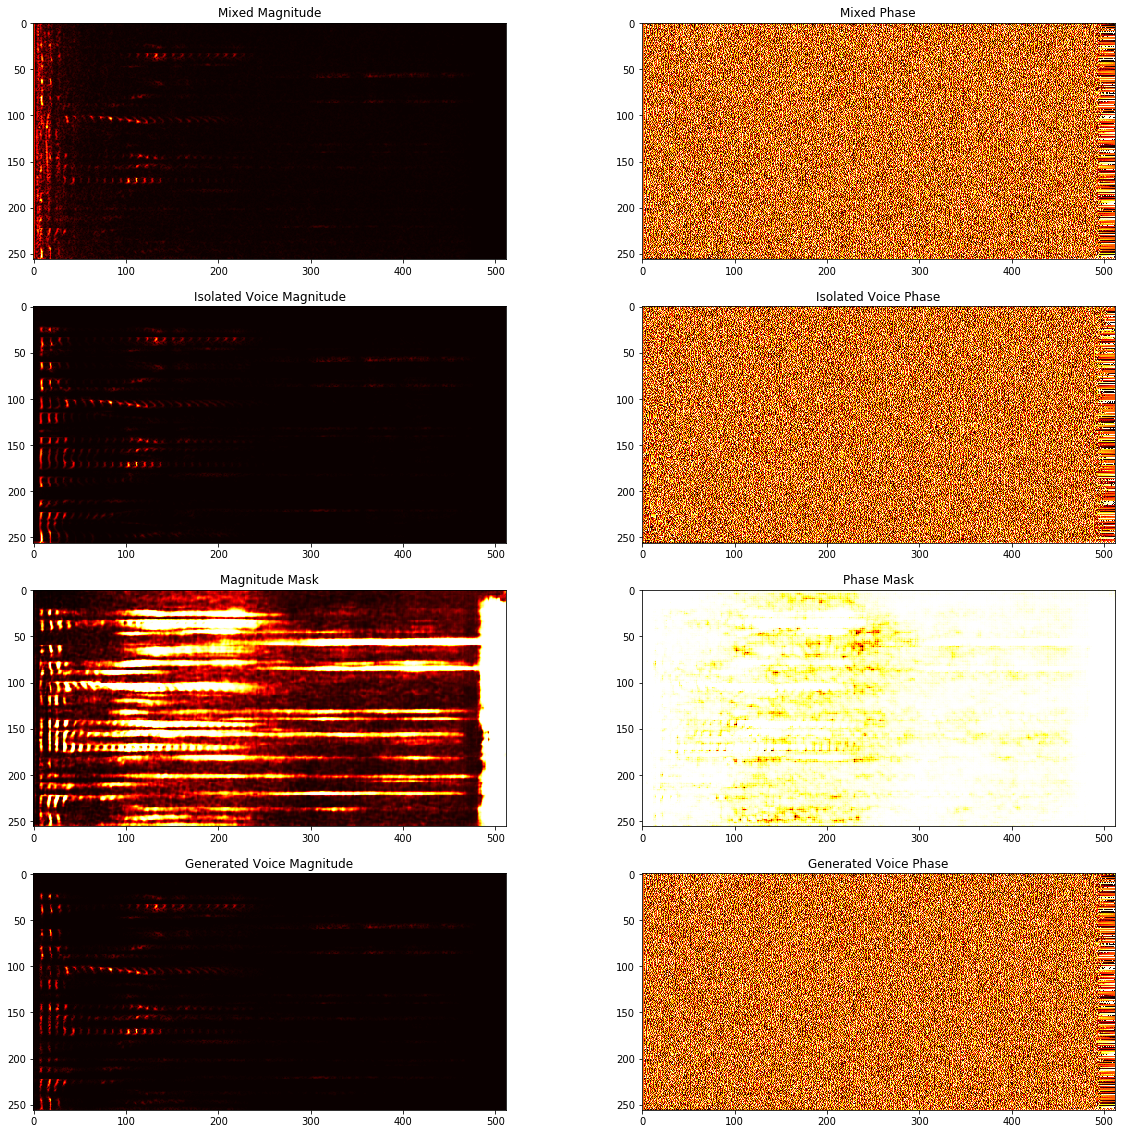

In [45]:
i=7

fig, ax = plt.subplots(4,2, figsize=(20,20))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('Mixed Magnitude')
ax[0,1].imshow(mix_inp[i,:,:,1])
ax[0,1].set_title('Mixed Phase')
ax[1,0].imshow(voice_inp[i,:,:,0])
ax[1,0].set_title('Isolated Voice Magnitude')
ax[1,1].imshow(voice_inp[i,:,:,1])
ax[1,1].set_title('Isolated Voice Phase')
ax[2,0].imshow(mask[i,:,:,0])
ax[2,0].set_title('Magnitude Mask')
ax[2,1].imshow(mask[i,:,:,1])
ax[2,1].set_title('Phase Mask')
ax[3,0].imshow(voice_est[i,:,:,0])
ax[3,0].set_title('Generated Voice Magnitude')
ax[3,1].imshow(voice_est[i,:,:,1])
ax[3,1].set_title('Generated Voice Phase')
plt.savefig(os.path.join(folder, 'mag_phase_example_2.png'))
plt.show()

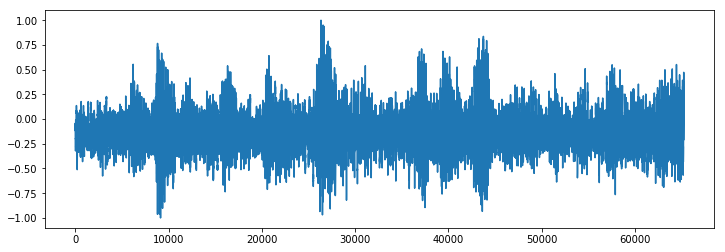

In [46]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

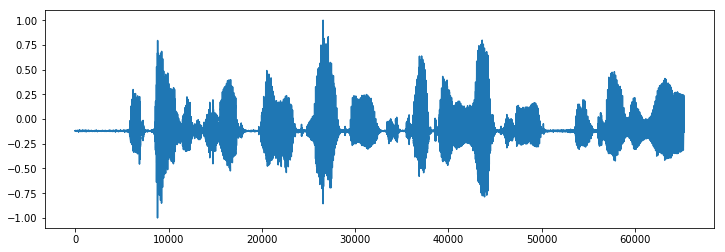

In [47]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

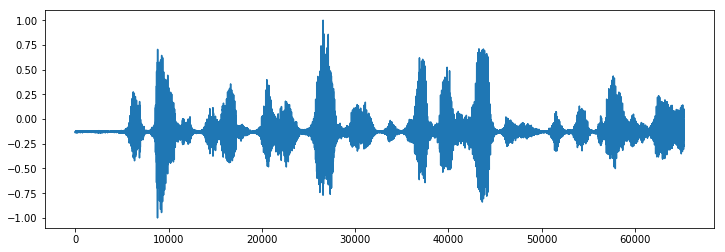

In [48]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

In [49]:
folder = 'audio_examples'
sf.write(os.path.join(folder,'voice_est_mag_phase_example_2.wav'), voice_est_wave[i], sample_rate)

In [ ]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 500
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        _, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        #_, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        #epoch_m_loss.append(m_loss)
        #epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        #epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        #epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        #print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
        #                                                                       empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))